In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [2]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))



In [3]:
# station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
station = ee.Geometry.Point(-74.860826362721,43.82503425692791)

Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[43.82503425692791, -74.860826362721], controls=(WidgetControl(options=['position', 'transparent_bg…

In [4]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];


In [5]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    
    bad2 = cdo.where((cdo.gte(0)),1).rename("bad2");
    co= cdo.multiply(bad2).rename("CO");
    mask = co.neq(0);

    return img.addBands([co]).clip(lake).updateMask(mask)
#     return ee.Image(img
#       .addBands(co)
#       .clip(lake)
#       .updateMask(mask)
#     )   
#         #return img.addBands([co])


In [6]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   

#l5 = l5


In [7]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \

#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));




In [8]:
print(lall.size().getInfo())


437


In [9]:
# image_list = lall.toList(15)
# date= lall.get()

In [10]:
def reflectance(img):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).select(STD_NAMES)
    return img.set('date', img.date().format()).set('reflectance',reflectance_values)

In [11]:
map_reflectance = lall.map(reflectance)


In [12]:
list_relfectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['date','reflectance']).values().get(0)
# Assuming `list_relfectance` is the list you want to modify



In [31]:
df_reflectance = pd.DataFrame(list_relfectance.getInfo(), columns=['date','reflectance'])
pd.set_option('display.max_rows', None)
df_reflectance['date'] = pd.to_datetime(df_reflectance['date'])
df_reflectance['date'] = df_reflectance['date'].dt.date


df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})



df_reflectance

,date,reflectance
0,1984-07-03,"{'QA': 5440, 'blue': 0.05113000000000001, 'gre..."
1,1984-09-21,{}
2,1984-10-07,{}
3,1984-11-08,{}
4,1985-10-26,{}
5,1986-08-26,{}
6,1986-11-30,{}
7,1987-06-10,{}
8,1988-05-27,{}
9,1988-06-12,"{'QA': 5440, 'blue': 0.027122499999999994, 'gr..."


In [39]:


for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            print(f"Band: {band}, Reflectance: {value}")
        print(f"Date: {date}")
    print()
    




Band: blue, Reflectance: 0.05113000000000001
Band: green, Reflectance: 0.05437500000000001
Band: red, Reflectance: 0.03432750000000001
Band: nir, Reflectance: 0.0716175
Band: swir1, Reflectance: 0.013509999999999994
Band: swir2, Reflectance: 0.007047499999999984
Band: temp, Reflectance: 20.391229759999987
Band: QA, Reflectance: 5440
Date: 1984-07-03









Band: blue, Reflectance: 0.027122499999999994
Band: green, Reflectance: 0.024180000000000007
Band: red, Reflectance: 0.01947750000000001
Band: nir, Reflectance: 0.04840749999999999
Band: swir1, Reflectance: 0.009385000000000004
Band: swir2, Reflectance: 0.0074325000000000085
Band: temp, Reflectance: 13.794451159999994
Band: QA, Reflectance: 5440
Date: 1988-06-12


Band: blue, Reflectance: 0.04144999999999999
Band: green, Reflectance: 0.035619999999999985
Band: red, Reflectance: 0.019917500000000005
Band: nir, Reflectance: 0.061387499999999984
Band: swir1, Reflectance: 0.007349999999999995
Band: swir2, Reflectance: 0.005562499999999

In [68]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)


# plt.plot(df_data['Band'], df_data['Reflectance'],'b.-')
# plt.ylim(0,0.2)
# plt.legend()

       Band   Reflectance        Date
0      blue      0.051130  1984-07-03
1     green      0.054375  1984-07-03
2       red      0.034328  1984-07-03
3       nir      0.071618  1984-07-03
4     swir1      0.013510  1984-07-03
5     swir2      0.007047  1984-07-03
6      temp     20.391230  1984-07-03
7        QA   5440.000000  1984-07-03
8      blue      0.027122  1988-06-12
9     green      0.024180  1988-06-12
10      red      0.019478  1988-06-12
11      nir      0.048407  1988-06-12
12    swir1      0.009385  1988-06-12
13    swir2      0.007433  1988-06-12
14     temp     13.794451  1988-06-12
15       QA   5440.000000  1988-06-12
16     blue      0.041450  1988-07-30
17    green      0.035620  1988-07-30
18      red      0.019918  1988-07-30
19      nir      0.061387  1988-07-30
20    swir1      0.007350  1988-07-30
21    swir2      0.005562  1988-07-30
22     temp     21.317513  1988-07-30
23       QA   5440.000000  1988-07-30
24     blue      0.023795  1992-05-22
25    green 

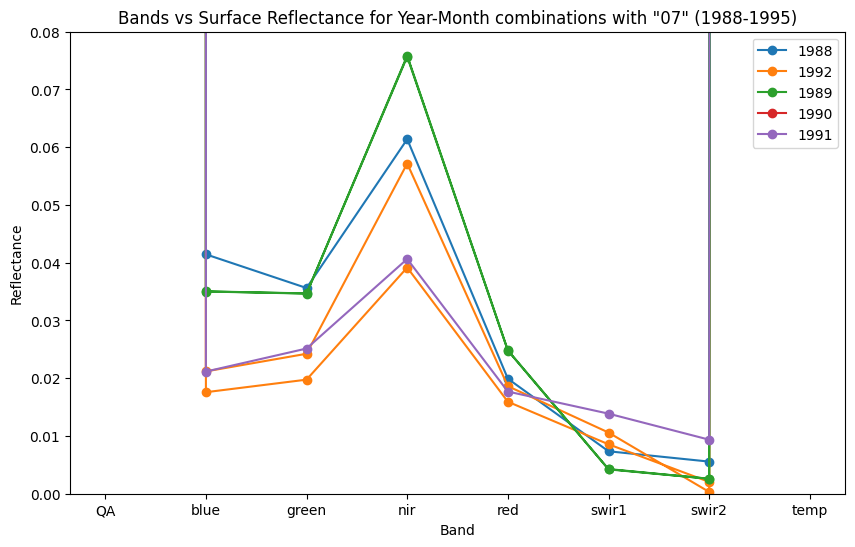

In [62]:
import matplotlib.pyplot as plt

# Create empty dictionaries to store the data for each year
data_by_year = {}

for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    # Check if the year is within the range from 1988 to 1995 and if the month in the date is "07"
    if 1988 <= date.year <= 1995 and date.month == 7:
        year = date.year
        
        # Check if the year exists in the dictionary, if not, create an empty list for it
        if year not in data_by_year:
            data_by_year[year] = {'band': [], 'reflectance': []}
        
        

        for band, value in reflectance.items():
            data_by_year[year]['band'].append(band)
            data_by_year[year]['reflectance'].append(value)

# Plotting the data
plt.figure(figsize=(10, 6))

# Iterate over the data for each year
for year, data in data_by_year.items():
    plt.plot(data['band'], data['reflectance'], marker='o', label=year)

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.08)
plt.title('Bands vs Surface Reflectance for Year-Month combinations with "07" (1988-1995)')
plt.legend()
plt.show()
